# Практическое задание по теме "Задача оттока: варианты постановки, возможные способы решения"

#### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [872]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [873]:
df = pd.read_csv("Churn_Modelling.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


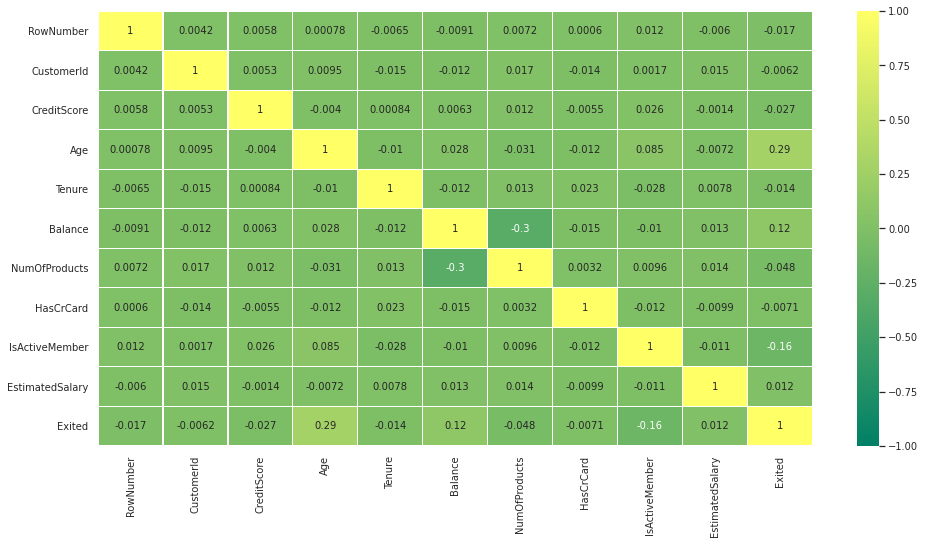

In [874]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot = True, cmap ="summer", linewidths=.2);

## Preprocessing 

In [875]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [876]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [877]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [878]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

## Modelling 

In [879]:
models_results = dict()

### GradientBoosting

#### Trying to reduce dimentionality

In [880]:
import sklearn.feature_selection as sf

# build pipeline with FeatureUnion
pipe = feature_processing

data = df.drop('Exited', axis=1)
pipe.fit(data)

X = pipe.transform(data)
y = df['Exited']

# reduce dimentionality
X = sf.SelectKBest(sf.f_regression, k=4).fit_transform(X, y)

In [881]:
pd.DataFrame(X).merge(y, how='left', left_index=True, right_index=True)

,0,1,2,3,Exited
0,0.0,0.0,1.0,0.293517,1
1,0.0,0.0,1.0,0.198164,0
2,0.0,1.0,0.0,0.293517,1
3,0.0,1.0,0.0,0.007457,0
4,0.0,0.0,1.0,0.388871,0
...,...,...,...,...,...
9995,0.0,1.0,0.0,0.007457,0
9996,0.0,0.0,1.0,-0.373958,0
9997,0.0,0.0,1.0,-0.278604,1
9998,1.0,1.0,0.0,0.293517,1


In [882]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, precision_recall_curve, confusion_matrix

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# build model
gb = GradientBoostingClassifier(n_estimators=20,
                               learning_rate=0.5, 
                               max_features=2, 
                               max_depth=2, 
                               random_state=0)
gb.fit(X_train, y_train)

# predicting
preds = gb.predict_proba(X_test)[:, 1]

# calc metrics
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
accuracy = accuracy_score(y_test, gb.predict(X_test))
print('Accuracy score=%.3f' % (accuracy))

# without dimentionality reduction
# Best Threshold=0.246036, F-Score=0.545, Precision=0.468, Recall=0.652
# Accuracy score=0.840

# with dimentionality reduction
# Best Threshold=0.323740, F-Score=0.560, Precision=0.527, Recall=0.597
# Accuracy score=0.845

models_results['GradientBoostingClassifier'] = {'f_score': fscore[ix], 
                                               'precision': precision[ix],
                                               'recall': recall[ix],
                                               'accuracy': accuracy,
                                               'roc_auc': roc_auc_score(y_test, preds),
                                               'conf_matrix': confusion_matrix(y_test, preds>thresholds[ix])}

Best Threshold=0.323740, F-Score=0.560, Precision=0.527, Recall=0.597
Accuracy score=0.845


In [883]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1758  233]
 [ 232  277]]


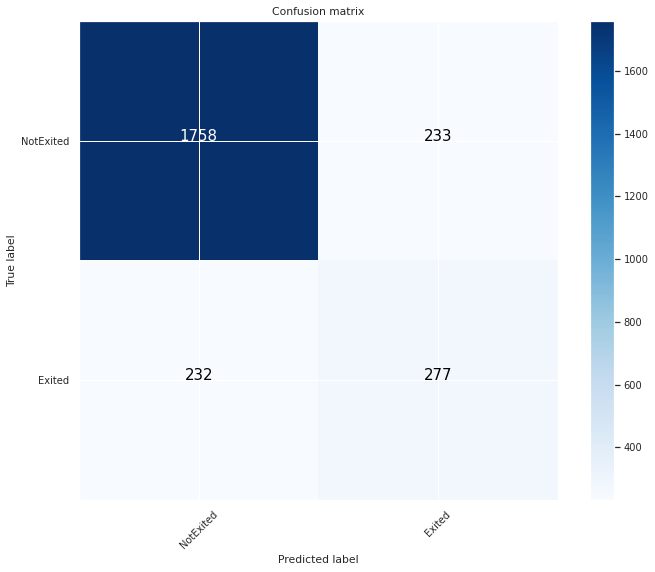

In [884]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NotExited', 'Exited'],
                      title='Confusion matrix')
plt.show()

ROC-AUC score: 0.8013462348742227


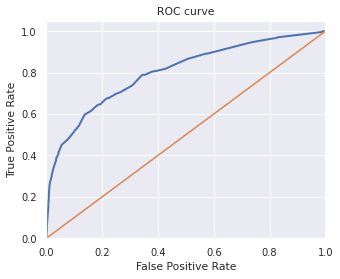

In [885]:
def plot_roc_curve(y_test, y_score, lw=2):
    sns.set(font_scale=0.9)
    sns.set_color_codes("muted")

    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show();
print('ROC-AUC score:', roc_auc_score(y_test, preds))
plot_roc_curve(y_test, preds)


Average precision-recall score: 0.58


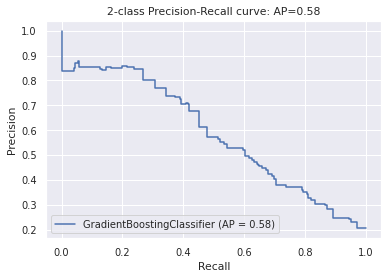

In [886]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, preds)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(gb, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision));

### XGBoost Classifier

Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633
Accuracy score=0.856
ROC-AUC score: 0.8609143898032303


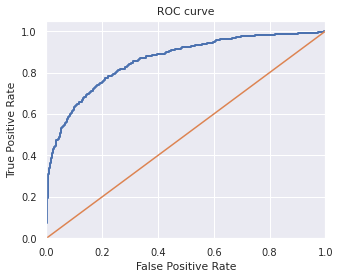

In [887]:
from xgboost import XGBClassifier

X = pipe.transform(data)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

xgb_clf = XGBClassifier(use_label_encoder=False, 
                       eval_metric=['auc'])
xgb_clf.fit(X_train, y_train)

preds = xgb_clf.predict_proba(X_test)[:, 1]
# calc metrics
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
accuracy = accuracy_score(y_test, xgb_clf.predict(X_test))
print('Accuracy score=%.3f' % (accuracy))

# with d-r
# Best Threshold=0.324692, F-Score=0.537, Precision=0.526, Recall=0.548
# Accuracy score=0.843
# ROC-AUC score: 0.7871670059471947

# without dimensionality reduction 
# Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633
# Accuracy score=0.856
# ROC-AUC score: 0.8609143898032303

print('ROC-AUC score:', roc_auc_score(y_test, preds))
plot_roc_curve(y_test, preds)

models_results['XGBoostClassifier'] = {'f_score': fscore[ix], 
                                      'precision': precision[ix],
                                      'recall': recall[ix],
                                      'accuracy': accuracy,
                                      'roc_auc': roc_auc_score(y_test, preds),
                                      'conf_matrix': confusion_matrix(y_test, preds>thresholds[ix])}


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


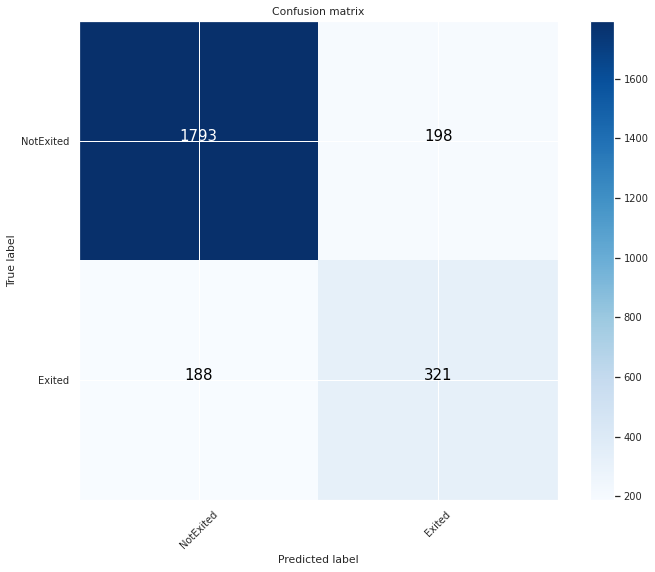

In [888]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NotExited', 'Exited'],
                      title='Confusion matrix')
plt.show()

### LogisticRegression

In [889]:
# build pipeline with FeatureUnion
pipe = feature_processing

data = df.drop('Exited', axis=1)
pipe.fit(data)

X = pipe.transform(data)
y = df['Exited']

Best Threshold=0.222800, F-Score=0.505, Precision=0.394, Recall=0.705
Accuracy score=0.814
ROC-AUC score: 0.7734915173289625


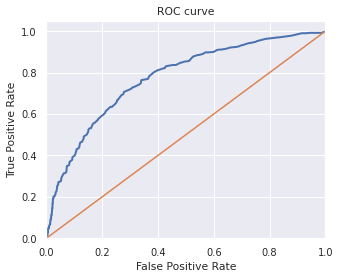

In [890]:
# reduce dimentionality
X = sf.SelectKBest(sf.f_regression, k=4).fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

# calc metrics
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
accuracy = accuracy_score(y_test, logreg.predict(X_test))
print('Accuracy score=%.3f' % (accuracy))

# with d-r
# Best Threshold=0.222800, F-Score=0.505, Precision=0.394, Recall=0.705
# Accuracy score=0.814
# ROC-AUC score: 0.7734915173289625

# without dimentionality reduction 
# Best Threshold=0.289511, F-Score=0.510, Precision=0.462, Recall=0.568
# Accuracy score=0.809
# ROC-AUC score: 0.7720745318570108

print('ROC-AUC score:', roc_auc_score(y_test, preds))
plot_roc_curve(y_test, preds)

models_results['LogisticRegression'] = {'f_score': fscore[ix], 
                                        'precision': precision[ix],
                                        'recall': recall[ix],
                                        'accuracy': accuracy,
                                        'roc_auc': roc_auc_score(y_test, preds),
                                        'conf_matrix': confusion_matrix(y_test, preds>thresholds[ix])}

Confusion matrix, without normalization
[[1442  549]
 [ 155  354]]


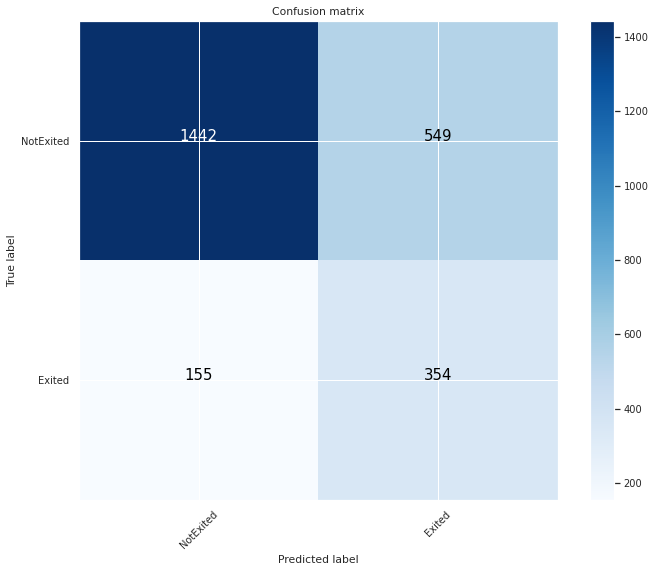

In [891]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NotExited', 'Exited'],
                      title='Confusion matrix')
plt.show()

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [892]:
pd.DataFrame(models_results)

,GradientBoostingClassifier,XGBoostClassifier,LogisticRegression
f_score,0.559853,0.62585,0.505278
precision,0.526863,0.619231,0.39364
recall,0.59725,0.632613,0.705305
accuracy,0.8452,0.8564,0.8144
roc_auc,0.801346,0.860914,0.773492
conf_matrix,"[[1758, 233], [232, 277]]","[[1793, 198], [188, 321]]","[[1442, 549], [155, 354]]"


In [893]:
best_clf = models_results['XGBoostClassifier']

_XGBoostClassifier model performed the best accuracy score and roc_auc_score and precision&recall balance_

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Я попытаюсь поразмышлять:
- Выручка:
1. 2$ - с каждого правильно классифицированного (True Positive)

- Траты:
1. 1\$ - на каждого, кого модель пометила как 'Exited', но он на самом деле 'NotExited' (False Negative)
2. Потеря потенциальных 2\$ с каждого, кого модель пометила 'NotExited', а он 'Exited' (False Positive) (?)

$\text{2TP - (1FN+2FP)}$

In [913]:
tn, fp, fn, tp = best_clf['conf_matrix'].ravel()

print('Без учета потенциальных потерь: %.f$' % (2*tp - (fn)))
print('C учетом потенциальных потерь: %.f$' % (2*tp - (fn + 2*fp)))

Без учета потенциальных потерь: 454$
C учетом потенциальных потерь: 58$


#### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [924]:
from sklearn.model_selection import GridSearchCV

params={'n_estimators':[10, 20, 50],
        'max_depth':[2, 3, 4, 6],
        'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
        'random_state': [42],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'gamma': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.5, 1],
        'use_label_encoder': [False]
        }

In [922]:
grid = GridSearchCV(xgb_clf,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'booster': 'gbtree',
 'gamma': 0.01,
 'learning_rate': 0.2,
 'max_depth': 2,
 'n_estimators': 50,
 'random_state': 42,
 'subsample': 0.5}

#### 5. (опционально) Еще раз провести оценку экономической эффективности

In [930]:
X = pipe.transform(data)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

xgb_clf = XGBClassifier(
                        use_label_encoder=False,
                        booster='gbtree',
                        gamma=0.01,
                        learning_rate=0.2,
                        max_depth=2,
                        n_estimators=50,
                        random_state=42,
                        subsample=0.5
                       )
xgb_clf.fit(X_train, y_train)

preds = xgb_clf.predict_proba(X_test)[:, 1]
# calc metrics
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
accuracy = accuracy_score(y_test, xgb_clf.predict(X_test))
print('Accuracy score=%.3f' % (accuracy))

models_results['XGBoostClassifier_gs'] = {'f_score': fscore[ix], 
                                         'precision': precision[ix],
                                         'recall': recall[ix],
                                         'accuracy': accuracy,
                                         'roc_auc': roc_auc_score(y_test, preds),
                                         'conf_matrix': confusion_matrix(y_test, preds>thresholds[ix])}

Best Threshold=0.329410, F-Score=0.644, Precision=0.626, Recall=0.662
Accuracy score=0.861


In [932]:
tn, fp, fn, tp = models_results['XGBoostClassifier_gs']['conf_matrix'].ravel()

print('Без учета потенциальных потерь: %.f$' % (2*tp - (fn)))
print('C учетом потенциальных потерь: %.f$' % (2*tp - (fn + 2*fp)))

Без учета потенциальных потерь: 499$
C учетом потенциальных потерь: 97$


GridSearch помог.

##### Ссылки
http://hyperopt.github.io/hyperopt/

https://arxiv.org/pdf/1907.03947.pdf

https://arxiv.org/pdf/1802.02301.pdf

https://arxiv.org/list/stat.ML/recent

https://scikit-learn.org/stable/modules/grid_search.html

https://scikit-learn.org/stable/modules/compose.html